#HW 3:

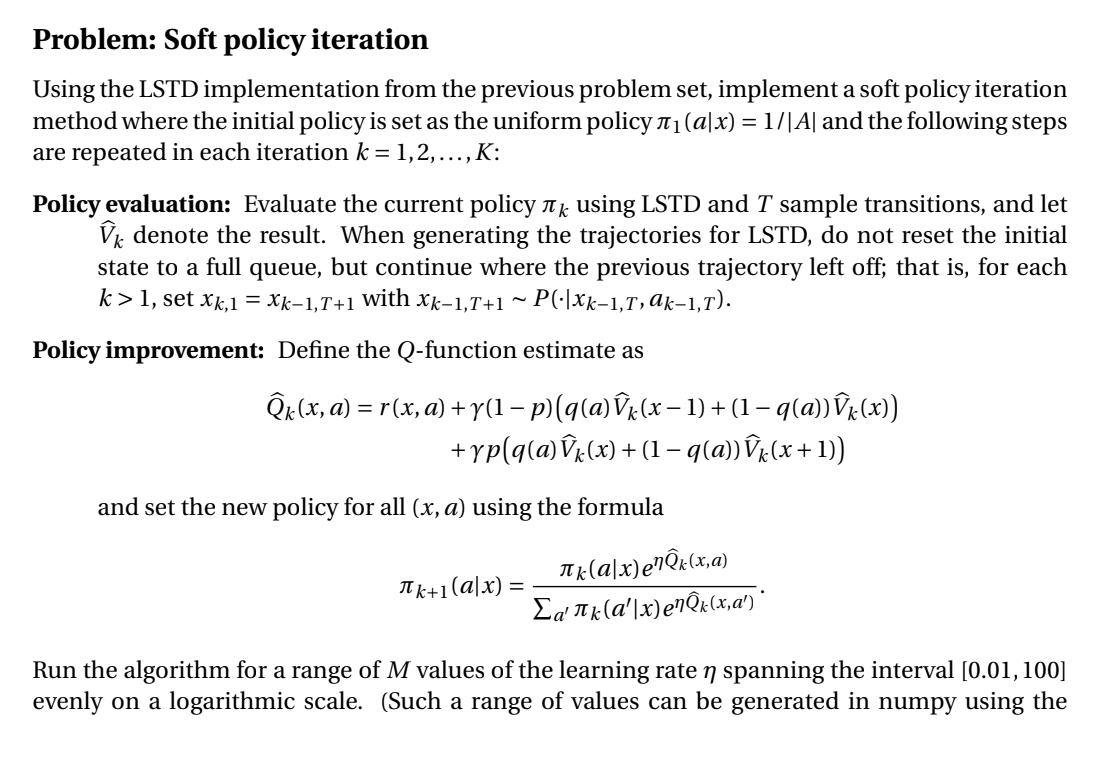

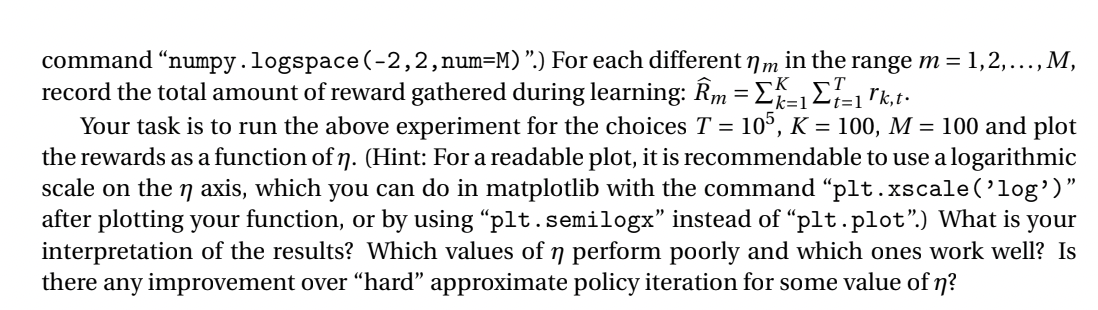

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
def reward(x, N, c):
  return -(x/N)**2 - c

In [3]:
def pwl(N, state):
  fm = np.zeros(int(2 * N / 5))
  # first half of the entries:
  index = math.floor(state / 5)
  fm[index] = 1
  # second half of the entries:
  index_2 = int(index + N / 5)
  fm[index_2] = (state - 5 * (index)) / 5
  
  return fm

In [4]:
def LSTD(rewards_list, states_list, gamma = 0.9):
  #only works for pwl
  
  dim = 100
  value_vector = np.zeros(dim)
  b = 0
  AB = 0

  for t in range(len(states_list)-1):
    b = b + rewards_list[t] * pwl(dim, states_list[t])
    AB = AB + np.matmul(np.matrix(pwl(dim, states_list[t])).T, 
                        (np.matrix(pwl(dim, states_list[t])) - 
                          gamma * np.matrix(pwl(dim, states_list[t+1]))))
    
  b = b / (len(states_list)-1)
  AB = AB / (len(states_list)-1)
  AB_inv = np.linalg.pinv(AB)
  theta = np.matmul(b, AB_inv)

  for state in range(dim):
    value_vector[state] = np.dot(theta, pwl(dim, state))

  return value_vector

In [5]:
def run_episode(initial_state, policy_vector, num_transitions = 10**4):
  # this simulates one episode, returns the list of rewards and states seen and the last state (for input next time)
  x = initial_state
  N = 100
  states = [x]
  rewards = []
  
  for t in range(num_transitions):
    # 1. pick an action by drawing from a bernoulli with p = prob of picking a low
    if np.random.binomial(1, policy_vector[x,0]) == 1:
      # choose low rate:
      a = 0
      c = 0
      q = 0.51
    
    # else choose high rate:
    else: 
      a = 1
      c = 0.01
      q = 0.6 # probability of successfully serving 1 client
    
    # 2. see the reward:
    r = reward(x, N, c)
    
    # 3. see the next state:
    # 3.1. probabilities:     
    if x == 0: #only possible change is for the queue to go up by one
      p_increase = 0.5 * (1 - q)
      p_no_change = 0.5 * (1 + q)
      p_decrease = 0

    elif x == N-1: #only possible change is for the queue to go down by one
      p_increase = 0
      p_no_change = 1 - 0.5 * q
      p_decrease = 0.5 * q 

    else: 
      p_increase = 0.5 * (1 - q)
      p_no_change = 0.5
      p_decrease = 0.5 * q

    P = [p_decrease, p_no_change, p_increase]
    
    # 3.2. draw the next state:
    x = np.random.choice([x - 1, x, x + 1], p = P)

    # 4. Save to list
    rewards.append(r)
    states.append(x)

  return rewards, states, x

In [6]:
def reward_matrix(N):
  # this generates a matrix that stacks the reward vectors associates with each action
  reward_matrix = np.zeros((N, 2))
  reward_matrix[:,0] = [-(x/N)**2 for x in range(N)]
  reward_matrix[:,1] = [(-(x/N)**2 - 0.01) for x in range(N)]
  
  return reward_matrix

In [7]:
initial_state = 99
policy_vector = np.ones((100,2)) * 0.5
next_policy = np.zeros((100,2))
Q_est = np.ones((100, 2))
reward_m = reward_matrix(100)
gamma = 0.9
p = 0.5
M = 50 # number of etas
K = 50 # number of policy updates
num_transitions = 10**4
rewards_gathered = []

for eta in tqdm(list(np.logspace(-2,2,num=M)), desc = "ETAs loop", leave = True):
  total_rewards = 0
  try:
    for k in range(K):
      # interact with the environment using the current policy:
      rewards_list, states_list, last_state = run_episode(initial_state, policy_vector, num_transitions)
      initial_state = last_state # this makes sure that the next iteration starts at the state we left off
      total_rewards += sum(rewards_list)

      # estimate V: 
      V_est = LSTD(rewards_list, states_list)
      V_est_prev = np.insert(V_est[:-1], 0, V_est[0]) # this is just offsetting the V_est vector by one to get a vector with the value of the previous states. for x = 0, we have a special case
      V_est_post = np.append(V_est[1:], V_est[99])

      # estimate Q:
      for a in [0, 1]:
        if a == 0:
          q = 0.51
        else:
          q = 0.6

        Q_est[:, a] = reward_m[:, a] + gamma * (1 - p) * (q * V_est_prev + (1 - q) * V_est) + gamma * p * (q * V_est + (1 - q) * V_est_post)

      # update the policy:

      for x in range(100):
        next_policy[x, 0] = policy_vector[x, 0] * np.e ** (eta * Q_est[x, 0]) / (policy_vector[x, 0] * np.e ** (eta * Q_est[x, 0]) + policy_vector[x, 1] * np.e ** (eta * Q_est[x, 1]))
        next_policy[x, 1] = 1 - next_policy[x, 0]
      
      policy_vector = next_policy
  except:
    total_rewards = -5000

  rewards_gathered.append(total_rewards)


ETAs loop:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


## Plot:

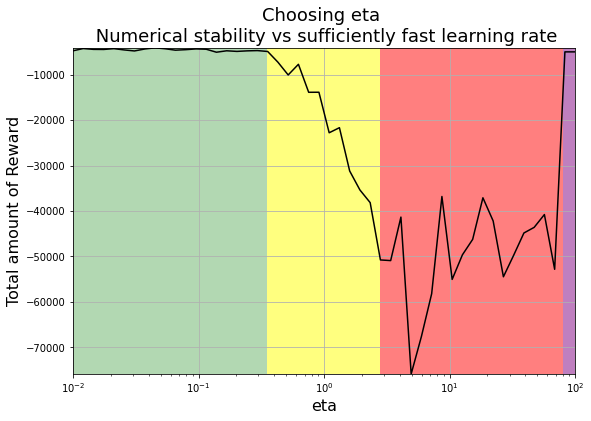

In [ ]:
fig, ax = plt.subplots(figsize = (9,6))

x = list(np.logspace(-2,2,num=M))
y = rewards_gathered

ax.set_xscale('log')
ax.set_title('Choosing eta \n Numerical stability vs sufficiently fast learning rate', size = 18)
ax.set_xlabel('eta', fontsize = 16)
ax.set_ylabel('Total amount of Reward', fontsize = 16)
ax.plot(x, y, 'k')
ax.grid()
ax.margins(0)

b = 3.5 * 10**-1
c = 2.8
d = 80

ax.axvspan(10**-2, b, facecolor='green', alpha=0.3)
ax.axvspan(b, c, facecolor='yellow', alpha=0.5)
ax.axvspan(c, d, facecolor='red', alpha=0.5)
ax.axvspan(d, 10**2, facecolor='purple', alpha=0.5)

plt.show()

We observe 4 distinct types of $\eta$, from left to right:
- The lowest values, which offer the best rewards.
- Next, there is a set of values that transition from good results to bad ones.
- Following, we have an area of divergence where the rewards are lowest and show significant variance.
- Finally, for large etas, we have a cluster of points with cumulative rewards of -5000. This level of rewards is an arbitrary number that I assigned to the variable every time the program crashes due to numerical instability.

By inspecting the objects associated with the last $\eta$, which makes the program explode, we have:

In [ ]:
policy_vector[90:]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]])

Which stems from:

In [ ]:
print(np.e ** (Q_est[98, 0] * 100))
print(np.e ** (Q_est[98, 1] * 100))

0.0
0.0


(dividing by zero)

As for a "hard" assignment:

In [ ]:
initial_state = 99
policy_vector = np.ones((100,2)) * 0.5
next_policy = np.zeros((100,2))
Q_est = np.ones((100, 2))
reward_m = reward_matrix(100)
gamma = 0.9
p = 0.5
M = 50 # number of etas
K = 50 # number of policy updates
num_transitions = 10**4
rewards_gathered_hard = []

total_rewards_hard = 0
for k in range(K):
  # interact with the environment using the current policy:
  rewards_list, states_list, last_state = run_episode(initial_state, policy_vector, num_transitions)
  total_rewards_hard += sum(rewards_list)

  # estimate V: 
  V_est = LSTD(rewards_list, states_list)
  V_est_prev = np.insert(V_est[:-1], 0, V_est[0]) # this is just offsetting the V_est vector by one to get a vector with the value of the previous states. for x = 0, we have a special case
  V_est_post = np.append(V_est[1:], V_est[99])

  # estimate Q:
  for a in [0, 1]:
    if a == 0:
      q = 0.51
    else:
      q = 0.6

    Q_est[:, a] = reward_m[:, a] + gamma * (1 - p) * (q * V_est_prev + (1 - q) * V_est) + gamma * p * (q * V_est + (1 - q) * V_est_post)

  # update the policy:

  for x in range(100):
    if Q_est[x, 0] > Q_est[x, 1]:
      next_policy[x, 0] = 1
      next_policy[x, 1] = 0
  
  policy_vector = next_policy

rewards_gathered_hard.append(total_rewards)

For the sensible $\eta$s, that is, between 0.01 and 1, we have:

Text(0, 0.5, 'Total amount of Reward')

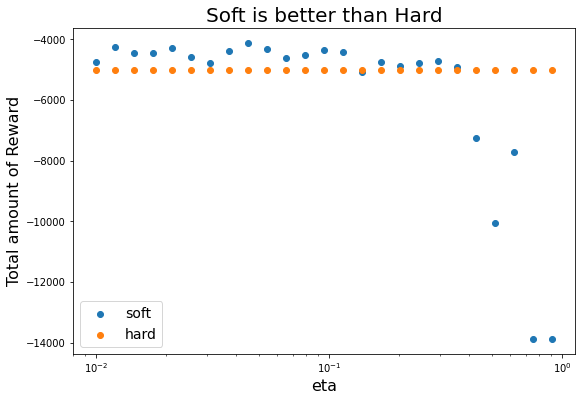

In [ ]:
plt.figure(figsize = (9, 6))

plt.scatter(x = list(np.logspace(-2,2,num=M))[0:25], y = rewards_gathered[0:25], label = "soft")
plt.scatter(x = list(np.logspace(-2,2,num=M))[0:25], y = rewards_gathered_hard * 25, label = "hard")
plt.xscale("log")
plt.title('Soft is better than Hard', size = 20)
plt.legend(fontsize = 14)
plt.xlabel('eta', fontsize = 16)
plt.ylabel('Total amount of Reward', fontsize = 16)

Note: Hard approximate policy iteration does not depend on $\eta$, I made a line from the single value it offers, for clearer comparisons.

It's clear that soft approximate policy iteration offers an improvement over the greedy approximate policy iteration.

In [ ]:
rewards_gathered_hard # this has nothing to do with the arbitrary number picked above for showing divergence

[-5000]